In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot

In [14]:
print(tf.config.list_physical_devices('GPU'))
mnist = keras.datasets.mnist

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
tf.__version__

'2.8.0'

In [16]:
mnist

<module 'keras.api._v2.keras.datasets.mnist' from '/Users/hardik/miniforge3/lib/python3.9/site-packages/keras/api/_v2/keras/datasets/mnist/__init__.py'>

In [17]:
(x_train_temp,y_train),(x_test_temp,y_test) = mnist.load_data()

In [18]:
x_train_temp.shape

(60000, 28, 28)

In [19]:
x_train = np.empty((60000, 32, 32))

In [20]:
x_test = np.empty((10000, 32, 32))

In [21]:

for index in tqdm( range( len(x_train_temp))):
  x_train[index] =  np.pad(x_train_temp[index], [(0, 4), (0, 4)], mode='constant')

for index in tqdm( range( len(x_test_temp))):
  x_test[index] =  np.pad(x_test_temp[index], [(0, 4), (0, 4)], mode='constant')

100%|██████████| 10000/10000 [00:00<00:00, 66988.50it/s]


In [22]:
d = x_test[0]
print(d.shape)

(32, 32)


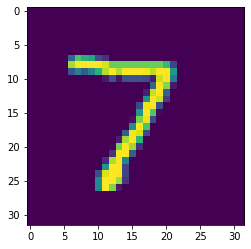

In [23]:
plt.imshow(x_test[0])

In [24]:

# x_train = keras.utils.normalize(x_train,axis=1)
# x_test = keras.utils.normalize(x_test,axis=1)

model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
# output
model.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train,y_train, epochs=3)

Epoch 1/3
  20/1875 [..............................] - ETA: 10s - loss: 24.1951 - accuracy: 0.1078

2022-12-24 16:07:40.050485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 9s 5ms/step - loss: 1.9975 - accuracy: 0.3586
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 1.1668 - accuracy: 0.5525
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7528 - accuracy: 0.7569


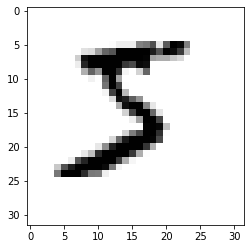

In [25]:
plt.imshow(x_train[0], plt.cm.binary)

In [26]:
val_loss, val_acc = model.evaluate(x_test,y_test)

 22/313 [=>............................] - ETA: 1s - loss: 0.6263 - accuracy: 0.8267

2022-12-24 16:08:13.313711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 0.5710 - accuracy: 0.8473


In [27]:
print(val_loss, val_acc)

0.5709882378578186 0.8473000526428223


## Model Quantization (Quantization aware training)

In [28]:
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

In [29]:
q_aware_model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32)           3         
 er)                                                             
                                                                 
 quant_flatten_1 (QuantizeWr  (None, 1024)             1         
 apperV2)                                                        
                                                                 
 quant_dense_3 (QuantizeWrap  (None, 16)               16405     
 perV2)                                                          
                                                                 
 quant_dense_4 (QuantizeWrap  (None, 16)               277       
 perV2)                                                          
                                                                 
 quant_dense_5 (QuantizeWrap  (None, 10)              

In [30]:
q_aware_model.fit(x_train,y_train, epochs = 3)

Epoch 1/3
   1/1875 [..............................] - ETA: 10:57 - loss: 3.0463 - accuracy: 0.1562

2022-12-24 16:08:25.207855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 26s 14ms/step - loss: 0.7823 - accuracy: 0.7499
Epoch 2/3
1875/1875 [==============================] - 24s 13ms/step - loss: 0.4140 - accuracy: 0.8853
Epoch 3/3
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3404 - accuracy: 0.9051


In [31]:
q_aware_model.evaluate(x_test,y_test)

 14/313 [>.............................] - ETA: 2s - loss: 0.2774 - accuracy: 0.9196

2022-12-24 16:09:40.221391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.3186 - accuracy: 0.9154


[0.3185500502586365, 0.9154000282287598]

In [32]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((x_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8

In [35]:
tflite_quant_model = converter.convert()

2022-12-24 16:10:22.207564: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/tmpe3cfviuv/assets


INFO:tensorflow:Assets written to: /var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/tmpe3cfviuv/assets
/Users/hardik/miniforge3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-24 16:10:24.507103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-12-24 16:10:24.507117: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-12-24 16:10:24.507521: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/tmpe3cfviuv
2022-12-24 16:10:24.509112: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-12-24 16:10:24.509117: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if prese

In [36]:
q_aware_model.save('../data/quantized_mnist_new')

INFO:tensorflow:Assets written to: ../data/quantized_mnist_new/assets


INFO:tensorflow:Assets written to: ../data/quantized_mnist_new/assets


In [37]:
with open ("../data/quantized_mnist.tflite", 'wb') as f:
  f.write(tflite_quant_model)

In [38]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_path='../data/quantized_mnist.tflite')
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_flatten_1_input:0
shape: [ 1 32 32]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>


## Transpilation

In [1]:
from Transpiler import transpile

In [3]:
transpile()

In [ ]:
new_model = keras.models.load_model('../data/hand_written_model')

In [ ]:
predictions = new_model.predict([x_test])

In [ ]:
idx = 6
plt.imshow(x_test[idx])
print(np.argmax(predictions[idx]))
plt.imshow(x_test[idx],plt.cm.binary)

In [ ]:
predictions

In [ ]:
(x_train_new,y_train_new),(x_test_new,y_test_new) = mnist.load_data()

In [ ]:
plt.imshow(x_train_new[0])

In [ ]:
predictions = model.predict([x_test])
# model.predict([x_train[0]])
predictions.shape

In [ ]:
index = 10
plt.imshow(x_test[index])
print(np.argmax(predictions[index]))

In [ ]:
with open('../data/digit_7.bin', 'wb') as f:
    f.write(x_test_new[0])

In [ ]:
seven = x_test_new[0]

In [ ]:
seven = np.pad(seven, [(0, 4), (0, 4)], mode='constant')

In [ ]:
seven.shape

In [ ]:
plt.imshow(seven)

In [ ]:
with open('../data/digit_7.bin', 'wb') as f:
    f.write(seven)

In [ ]:
! pip install tensorflow-model-optimization